# Chapter 3: Machine Learning

Applying machine learning models to predict COVID-19 clinical severity in ESKD patients as the target variable (Y), using plasma proteomic features (X) as predictors. 

COVID-19 clinical severity was selected as the prediction target because it represents the most clinically meaningful outcome in this cohort and exploratory analyses indicated that alternative variables exhibited limited variability and were therefore less informative for modelling.

An additional advantage of this approach is that it allows a direct comparison between the performance of our machine learning models and the results of our earlier statistical analyses, enabling us to assess the extent to which data-driven models capture the same biological patterns identified through hypothesis-driven methods.

# 3.1 Data preprocessing

In [2]:
#loading in libraries
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons, make_classification, make_regression
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

# Set the style for our visualisations
sns.set_style("whitegrid")
sns.set_palette("deep")

%matplotlib inline

# Set random seed for reproducibility of all random operations performed during data preprocessing and model training
np.random.seed(42)


In [3]:
#Import data sets and splitting proteins vs metadata
# Import dataset Senne
#combined_dataset = pd.read_csv("/content/drive/MyDrive/Biomedische Wetenschappen UGent/LSABD Group project/combined_dataset.csv")

#import dataset Nele
#combined_dataset = pd.read_csv("/content/drive/MyDrive/UGent/1e Ma/Large Scale Analysis/Oefeningen/group_project/combined_dataset.csv")

#import dataset Benthe
combined_dataset = pd.read_csv("combined_dataset.csv")

combined_dataset_protein = combined_dataset.iloc[:,0:7241]
combined_dataset_features = combined_dataset.iloc[:,7242:7258]
print("Proteomics shape:", combined_dataset_protein.shape)
print("Metadata shape:", combined_dataset_features.shape)

Proteomics shape: (241, 7241)
Metadata shape: (241, 16)


## 3.1.1 Explore the feature variable

In [4]:
#input features (X)
feature = combined_dataset_protein
print("Input feature matrix shape (feature):", feature.shape)

Input feature matrix shape (feature): (241, 7241)


We first check the data types of the feature

In [5]:
feature.dtypes

Unnamed: 0     object
CRYBB2        float64
RAF1          float64
ZNF41         float64
ELK1          float64
               ...   
ZNF264        float64
ATP4B         float64
DUT           float64
UBXN4.1       float64
IRF6          float64
Length: 7241, dtype: object

The dataset contains only numeric features (float values), so we do not need to handle categorical variables.

We will now check for missing values.

In [6]:
feature.isnull().sum()

Unnamed: 0    0
CRYBB2        0
RAF1          0
ZNF41         0
ELK1          0
             ..
ZNF264        0
ATP4B         0
DUT           0
UBXN4.1       0
IRF6          0
Length: 7241, dtype: int64

This result indicates that no missing values are present. Therefore, no imputation or removal of observations is required at this stage of preprocessing.


## 3.1.2 Explore the target variable

We will explore the target column to check which severity categories are present in the dataset.

In [7]:
#target variable (Y)
targets = combined_dataset_features["WHO_temp_severity"]
print("Unique severity labels:", targets.unique())

Unique severity labels: ['NEGATIVE' 'moderate' 'severe' 'critical' 'mild']


In [8]:
#look at the first five rows and change NEGATIVE to negative
target = targets.str.lower()
print(target.head())

0    negative
1    moderate
2      severe
3    moderate
4      severe
Name: WHO_temp_severity, dtype: object


Since the previous output showed that the severity categories appeared in an illogical order, this code will correct the ordering by redefining target as an ordered categorical variable and then computes the class frequencies to check the distribution of the target classes

In [9]:
#check if the 5 severity groups are evenly distributed 
order = ["negative", "mild", "moderate", "severe", "critical"] 
target = pd.Categorical(target,categories=order,ordered=True) 
target.value_counts()

negative     53
mild        101
moderate     49
severe       25
critical     13
Name: count, dtype: int64

We can visualise this distribution using a barplot. 

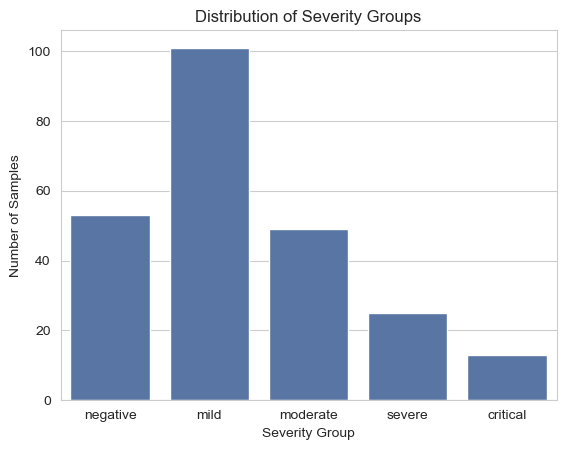

In [10]:
sns.countplot(x=target)
plt.title('Distribution of Severity Groups')
plt.xlabel('Severity Group')
plt.ylabel('Number of Samples')
plt.show()


The barplot illustrates an imbalance across the severity groups. It shows that there are more samples in the mild group compared to the other groups. Also the critical group is a lot lower than the other groups. This imbalance should be considered when training the models, as it may influence the model's performance, potentially favoring the majority class (mild) over the others.

## 3.1.3 Log-transformation

As part of the preprocessing, we normalize the data to account for the highly skewed distribution of the proteomic measurements. This is achieved by applying a log transformation, which reduces the impact of extreme values and produces a more stable feature distribution for subsequent modelling.

In [11]:
# Select only numeric columns from the proteomics matrix
feature_numeric = feature.select_dtypes(include=[np.number])
print("Numeric proteomics shape:", feature_numeric.shape)
#log transformation
feature_log = np.log(feature_numeric)
print("Log-transformed feature shape:", feature_log.shape)
print(feature_log.head())

Numeric proteomics shape: (241, 7240)
Log-transformed feature shape: (241, 7240)
     CRYBB2      RAF1     ZNF41      ELK1    GUCA1A     BECN1      OCRL  \
0  5.822750  5.711420  5.428468  7.297159  5.837439  5.473950  7.549872   
1  5.719984  6.759603  4.888844  6.613653  5.547129  5.164214  7.652451   
2  5.764564  6.874405  4.964242  6.586723  5.494706  5.082646  7.422732   
3  5.853638  6.267770  5.202907  6.725394  5.705115  5.283711  7.779676   
4  5.700778  6.604350  5.030438  6.507875  5.629777  5.182907  7.444775   

      SPDEF     SNAI2    KCNAB2  ...     YIPF6       NPW  LRRC25.1    LRRC24  \
0  6.322745  6.247269  5.866185  ...  6.020052  9.042714  5.557986  5.974064   
1  6.483719  6.175659  5.930652  ...  5.700444  7.322114  5.373425  5.534575   
2  6.556636  6.170656  6.133398  ...  5.738828  6.705517  5.526249  5.247550   
3  6.314996  6.256901  6.039064  ...  5.785055  6.760183  5.508173  5.764878   
4  6.335054  6.132530  5.983180  ...  5.802420  7.608077  5.525054  


The distribution appears more regular after log-transformation because the transformation reduces the influence of extreme values. Large protein expression values are compressed into a narrower range, while lower-intensity measurements become relatively more prominent. This stabilizes variance and improves the suitability of the features for downstream machine-learning algorithms that are sensitive to scale and skewness.


A single, randomly selected protein will be visualised as a representative example to demonstrate the typical distributional pattern observed across the proteomic features, allowing us to illustrate the effect of the log transformation without plotting all 7,241 proteins individually.

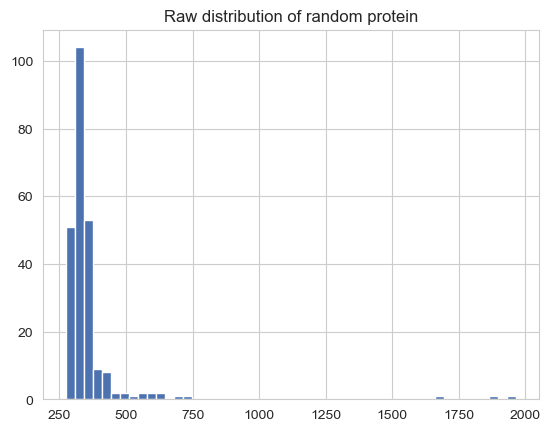

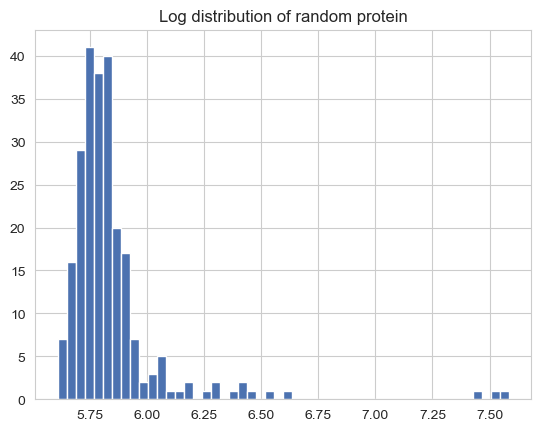

In [12]:
# Plot raw distribution of random protein 
feature_numeric.iloc[:,0].hist(bins=50)
plt.title("Raw distribution of random protein")
plt.show()

# Plot log-transformed distribution of random protein 
feature_log.iloc[:,0].hist(bins=50)
plt.title("Log distribution of random protein")
plt.show()


The raw distribution of a randomly selected protein shows strong right skewness, with most values concentrated at the lower end and a long tail of large intensity measurements. After applying a log transformation, the distribution becomes more compressed and considerably less skewed. This indicates that the log transform effectively reduces the influence of extreme values and produces a more stable, approximately symmetric feature distribution suitable for machine-learning models.

# 3.2 Data splitting

We split the dataset into training, validation and test subsets using a two-step stratified procedure. The initial split isolates 20% of the data as an independent test set to ensure an unbiased final evaluation. The remaining data are further divided into training and validation sets, which enables model tuning and selection without leaking information from the test set.

Stratification is applied in both splits to preserve the original class distribution of the severity groups across all subsets. This is essential given the imbalance in class frequencies, as it ensures that the training, validation and test sets all reflect the true population structure. Printing the class distributions and barplots verify that the stratification worked as intended.

Training set: 153 samples (63.5%)
Validation set: 39 samples (16.2%)
Test set: 49 samples (20.3%)

Total samples: 241

Class distribution in TRAIN set:
mild        0.424837
negative    0.215686
moderate    0.202614
severe      0.104575
critical    0.052288
Name: proportion, dtype: float64

Class distribution in VALIDATION set:
mild        0.410256
negative    0.230769
moderate    0.205128
severe      0.102564
critical    0.051282
Name: proportion, dtype: float64

Class distribution in TEST set:
mild        0.408163
negative    0.224490
moderate    0.204082
severe      0.102041
critical    0.061224
Name: proportion, dtype: float64


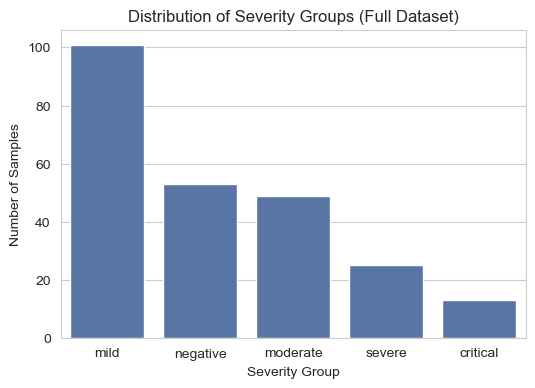

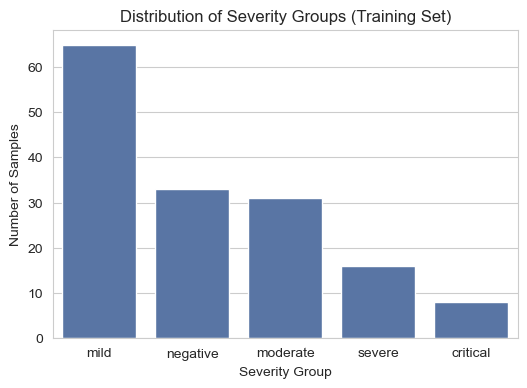

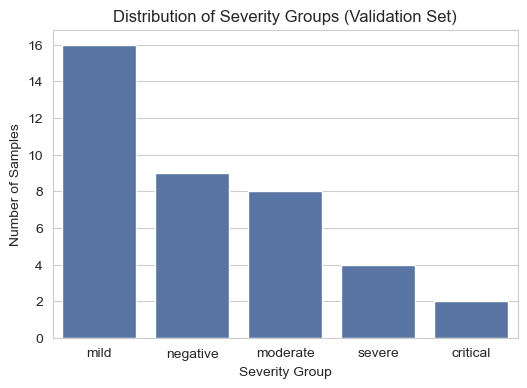

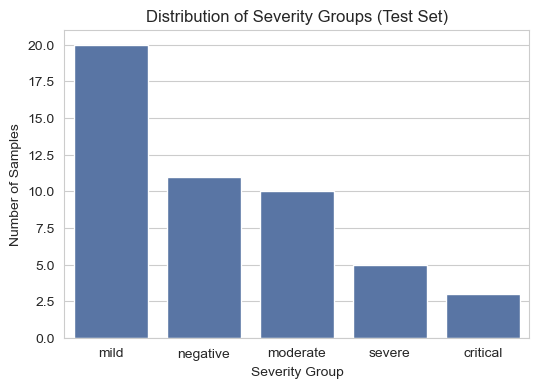

In [13]:

target = pd.Series(target).astype('category')
# First split: separate test set (20%)
train_validation_feature, test_feature, train_validation_target, test_target = train_test_split(feature_log, target, test_size=0.2, random_state=42, stratify= target)
# Second split: divide remaining into train (80% of temp) and validation (20% of temp)
train_feature, validation_feature, train_target, validation_target = train_test_split(
    train_validation_feature, train_validation_target, test_size=0.2, random_state=42, stratify=train_validation_target
)

print(f"Training set: {train_feature.shape[0]} samples ({train_feature.shape[0]/len(feature_log)*100:.1f}%)")
print(f"Validation set: {validation_feature.shape[0]} samples ({validation_feature.shape[0]/len(feature_log)*100:.1f}%)")
print(f"Test set: {test_feature.shape[0]} samples ({test_feature.shape[0]/len(feature_log)*100:.1f}%)")
print(f"\nTotal samples: {len(feature_log)}")

print("\nClass distribution in TRAIN set:") 
print(train_target.value_counts(normalize=True))
print("\nClass distribution in VALIDATION set:") 
print(validation_target.value_counts(normalize=True)) 
print("\nClass distribution in TEST set:") 
print(test_target.value_counts(normalize=True))

# Plot 1 — Complete dataset
plt.figure(figsize=(6,4))
sns.countplot(x=target, order=target.value_counts().index)
plt.title('Distribution of Severity Groups (Full Dataset)')
plt.xlabel('Severity Group')
plt.ylabel('Number of Samples')
plt.show()

# Plot 2 — Training set
plt.figure(figsize=(6,4))
sns.countplot(x=train_target, order=target.value_counts().index)
plt.title('Distribution of Severity Groups (Training Set)')
plt.xlabel('Severity Group')
plt.ylabel('Number of Samples')
plt.show()

# Plot 3 — Validation set
plt.figure(figsize=(6,4))
sns.countplot(x=validation_target, order=target.value_counts().index)
plt.title('Distribution of Severity Groups (Validation Set)')
plt.xlabel('Severity Group')
plt.ylabel('Number of Samples')
plt.show()

# Plot 4 — Test set
plt.figure(figsize=(6,4))
sns.countplot(x=test_target, order=target.value_counts().index)
plt.title('Distribution of Severity Groups (Test Set)')
plt.xlabel('Severity Group')
plt.ylabel('Number of Samples')
plt.show()


The dataset is split into training (63.5%), validation (16.2%), and test (20.3%) subsets, providing an appropriate balance between model fitting, tuning and unbiased evaluation. The class distributions across all three sets are nearly identical, confirming that stratification successfully preserved the original severity proportions. This consistency is important for reliable model training, especially given the imbalance between mild and critical cases. The corresponding barplots visually illustrate this, showing highly similar distributions of severity groups in the full dataset, training set, validation set and test set. 

# 3.3 Feature scaling

We visualized the distribution of a subset of ten random protein features to assess their scale and variability prior to feature scaling. This inspection helps identify large differences in magnitude across proteins, motivating the need for standardisation before model training.

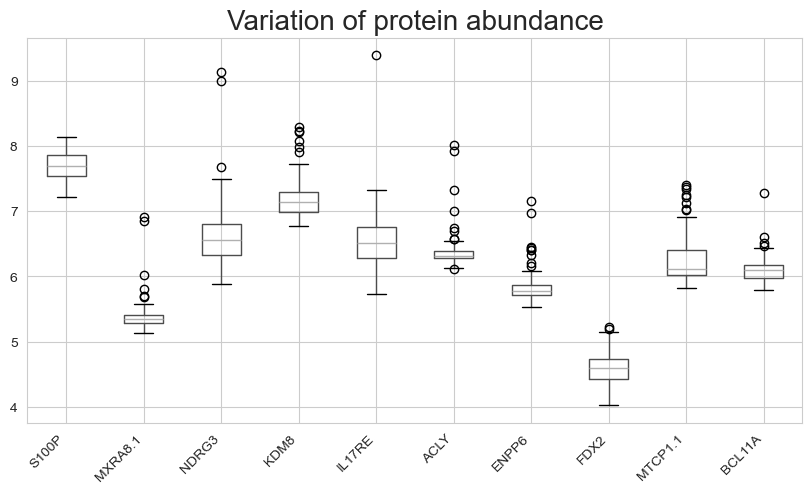

In [14]:
plt.figure(figsize=(10,5))
plt.title('Variation of protein abundance', fontsize = 20)
sample_10_train_feature = train_feature.sample(10, axis="columns", random_state = 10)
sample_10_train_feature.boxplot()
plt.xticks(rotation=45, ha = 'right')
plt.show()

In [15]:
#Get a summary of descriptive statistics for the dataset 
sample_10_train_feature.describe()

,S100P,MXRA8.1,NDRG3,KDM8,IL17RE,ACLY,ENPP6,FDX2,MTCP1.1,BCL11A
count,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000
mean,7.685421,5.375029,6.614542,7.188327,6.536371,6.364204,5.826936,4.595030,6.245619,6.094454
std,0.225628,0.208826,0.433829,0.271377,0.408236,0.229132,0.211686,0.226300,0.340423,0.180955
min,7.212811,5.132853,5.879974,6.771133,5.727499,6.107691,5.538515,4.027136,5.818301,5.788736
25%,7.538921,5.282696,6.328651,6.992005,6.285439,6.275515,5.715711,4.432007,6.016889,5.973810
50%,7.696394,5.340898,6.551794,7.134971,6.509216,6.320409,5.779817,4.601162,6.115892,6.092440
75%,7.862728,5.413876,6.798721,7.291588,6.751569,6.386711,5.867601,4.731803,6.408199,6.168355
max,8.143488,6.909853,9.127958,8.295524,9.389641,8.006701,7.157580,5.218191,7.406164,7.284547


The boxplot and the table above illustrate a wide variation in magnitude across protein intensities, with some proteins showing much higher or lower dynamic ranges than others.

## 3.3.1 Standardisation using StandardScaler

We standardise all protein features using StandardScaler, which transforms each variable to have a mean of 0 and a standard deviation of 1, making the data more uniform and suitable for algorithms that are sensitive to feature scale. The scaler is fitted only on the training data to avoid data leakage, and the learned parameters are applied to the validation and test sets, improving numerical stability and ensuring fair model comparison.

In [16]:
scaler = StandardScaler()
train_feature_scaled_array = scaler.fit_transform(train_feature)
validation_feature_scaled_array = scaler.transform(validation_feature)
test_feature_scaled_array  = scaler.transform(test_feature)

The functions return NumPy arrays. We convert them back to pandas dataframe for easier handling.

In [17]:
train_feature_scaled = pd.DataFrame(train_feature_scaled_array, columns=train_feature.columns)
validation_feature_scaled = pd.DataFrame(validation_feature_scaled_array, columns=validation_feature.columns)
test_feature_scaled = pd.DataFrame(test_feature_scaled_array, columns=test_feature.columns)

To see the effect of standardisation, we make a visualisation of the distribution before and after scaling. Because our dataset is very large, we decide to visualise a selection of the first 50 proteins as a representation for the whole dataset.

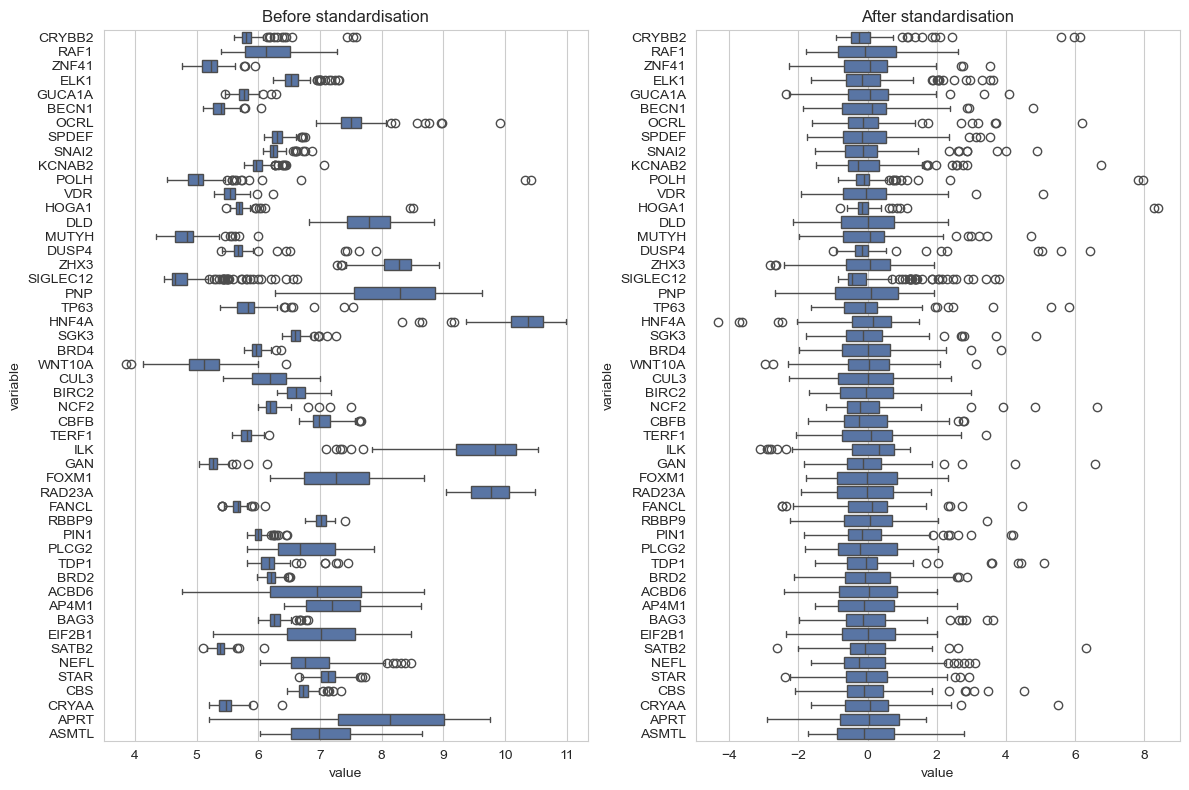

In [18]:
fig, axes = plt.subplots(figsize=(12, 8), ncols=2)

sns.boxplot(data=train_feature.iloc[:, :50].melt(), x="value", y="variable", ax=axes[0])
axes[0].set_title("Before standardisation")

sns.boxplot(data=train_feature_scaled.iloc[:, :50].melt(), x="value", y="variable", ax=axes[1])
axes[1].set_title("After standardisation")

plt.tight_layout()
plt.show()

Before standardisation, the protein features differ greatly in scale and variability, which can cause certain variables to dominate model training. After standardisation, all features are centered around zero with comparable variance, resulting in a more uniform feature space. This ensures that each protein contributes more equally to the model and improves the stability and performance of algorithms that are sensitive to feature magnitude.

## 3.4 Dimensionality Reduction and Visualisation using PCA
PCA is applied to project the high-dimensional proteomic data into a two-dimensional space, allowing us to visualize global structure and potential separation between severity groups. This step provides an intuitive assessment of whether meaningful patterns or clusters exist in the entire dataset before model training.

<Axes: title={'center': 'PCA of Proteomics Data (2D)'}, xlabel='principal component 1', ylabel='principal component 2'>

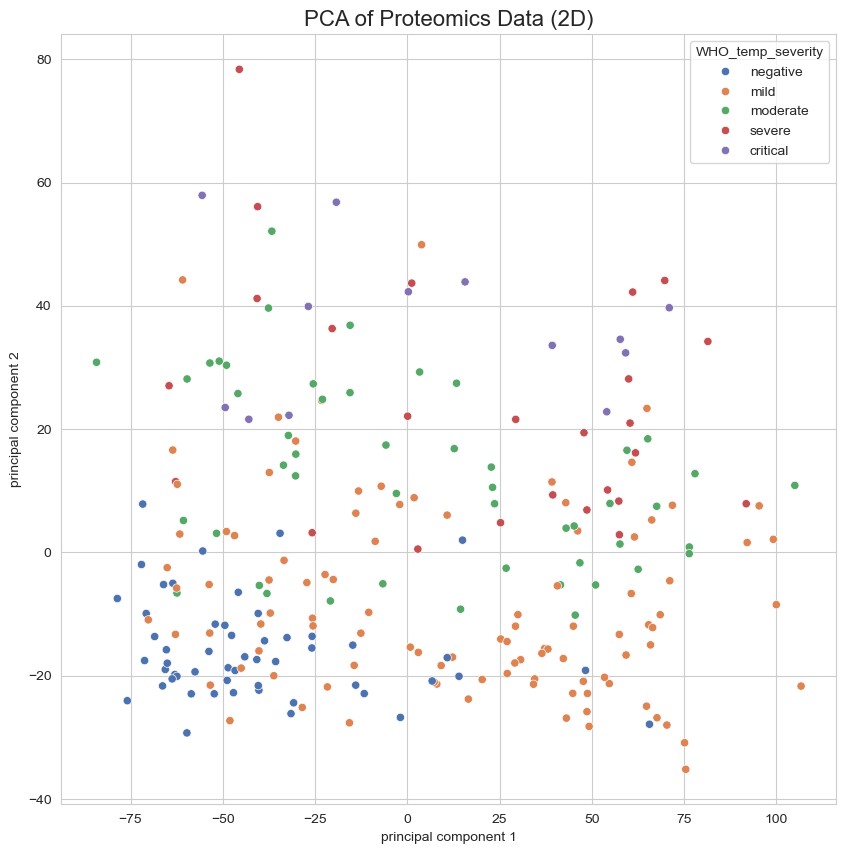

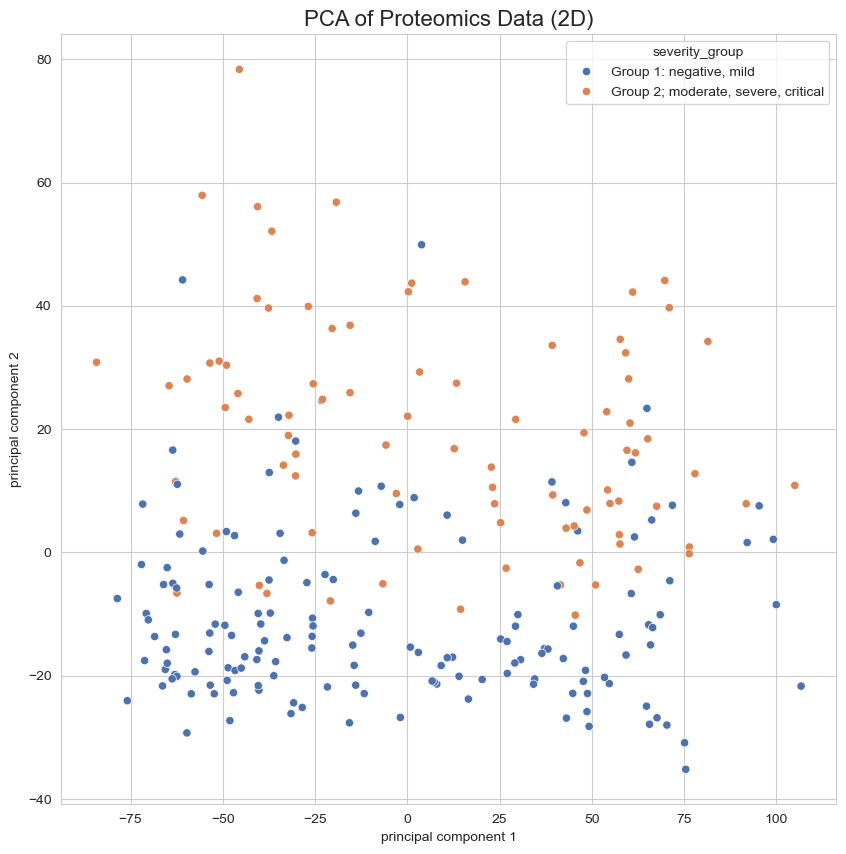

In [19]:
features_scaled = StandardScaler().fit_transform(feature_log)
target_series = pd.Series(target, name="WHO_temp_severity")
# PCA Projection to 2D dataframe
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(features_scaled)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, target_series], axis = 1)

# Visualisation
plt.figure(figsize=(10,10))
plt.title('PCA of Proteomics Data (2D)', fontsize=16)
sns.scatterplot(
    x ='principal component 1',
    y ='principal component 2',
    hue ='WHO_temp_severity',
    data = finalDf,
    palette ='deep'
)

#add a column to the dataframe
finalDf['severity_group'] = pd.DataFrame(finalDf['WHO_temp_severity'].apply(lambda x: 'Group 1: negative, mild' if x in ['negative','mild'] else 'Group 2; moderate, severe, critical'))

# Visualisation
plt.figure(figsize=(10,10))
plt.title('PCA of Proteomics Data (2D)', fontsize=16)
sns.scatterplot(
    x ='principal component 1',
    y ='principal component 2',
    hue ='severity_group',
    data = finalDf,
    palette ='deep'
)

In the first PCA plot, the five severity groups are shown in different colours. The groups almost completely overlap and no clear clustering or separation is visible. This indicates that the variation captured by the first two principal components is not primarily driven by COVID-19 severity. Because the individually coloured severity groups showed substantial overlap, a second PCA plot was generated to test whether combining them into broader categories might reveal clearer structure.

After merging the classes into low severity (negative/mild) and high severity (moderate/severe/critical), a mild pattern becomes visible: many low-severity samples appear below zero, while many high-severity samples appear above it. However, the overlap remains large, meaning the separation is weak and not meaningful for classification.

# 3.5 Model training
fitting 3 machine learning models

# 3.5.1 Logistic regression model

A multinomial logistic regression model with class_weight='balanced' will be trained on the standardised training data to predict COVID-19 severity categories based on plasma proteomic features. Model performance will be assessed on the scaled test set using balanced accuracy, a detailed classification report and a confusion matrix. The classification report provides precision, recall, macro F1-scores and support for each class, enabling a class-by-class evaluation. The macro average represents the unweighted mean of the per-class metrics and therefore reflects how well the model performs across all severity groups, independent of class size. In contrast, the weighted average accounts for class frequency, giving more influence to majority classes and thus better representing overall performance under class imbalance. The confusion matrix and corresponding heatmap help identify systematic misclassifications, offering insight into which severity categories are most difficult for the model to distinguish.

Test accuracy: 0.633

Classification report:
              precision    recall  f1-score   support

    negative       0.67      0.67      0.67         3
        mild       0.65      0.85      0.74        20
    moderate       0.44      0.40      0.42        10
      severe       1.00      0.64      0.78        11
    critical       0.25      0.20      0.22         5

    accuracy                           0.63        49
   macro avg       0.60      0.55      0.57        49
weighted avg       0.65      0.63      0.63        49

Confusion matrix:
 [[ 2  1  0  0  0]
 [ 0 17  3  0  0]
 [ 0  3  4  0  3]
 [ 0  4  0  7  0]
 [ 1  1  2  0  1]]


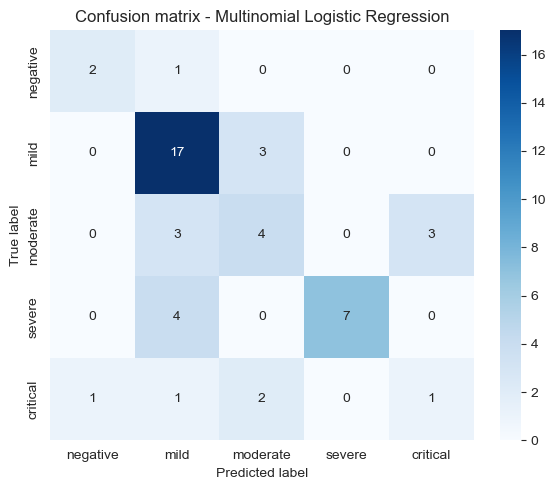

In [20]:
# Multinomial logistic regression with class_weight='balanced'
log_reg = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',        
    class_weight='balanced',
    max_iter=1000,
    n_jobs=-1              
)

# Fit model on scaled training data
log_reg.fit(train_feature_scaled, train_target) 

# Predictions and predicted probabilities on scaled test data
y_pred = log_reg.predict(test_feature_scaled)
y_proba = log_reg.predict_proba(test_feature_scaled)

# Accuracy 
acc = accuracy_score(test_target, y_pred)
print(f"Test accuracy: {acc:.3f}")

# Classification report per class
print("\nClassification report:")
print(classification_report(test_target, y_pred, target_names= order))

# Confusion matrix + heatmap
cm = confusion_matrix(test_target, y_pred)
print("Confusion matrix:\n", cm)

plt.figure(figsize=(6,5))
sns.heatmap(cm,
            annot=True,
            fmt="d",
            xticklabels= order,
            yticklabels= order,
            cmap="Blues")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion matrix - Multinomial Logistic Regression")
plt.tight_layout()
plt.show()



TThe model achieves a test accuracy of 0.63 and a macro F1-score of 0.57, indicating moderate overall performance. Negative and mild cases are classified reasonably well, but moderate, severe and especially critical cases are often misclassified. Most errors occur when higher-severity samples are mistaken for milder categories, reflecting both class imbalance and overlapping proteomic signatures. These results suggest that multinomial logistic regression is not sufficiently flexible to capture the more complex, non-linear structure of the data.

## 3.5.1.1 Feature importance  

We will compute the most influential coefficients of the multinomial logistic regression model to identify which proteins contribute most strongly to separating the COVID-19 severity categories.

In [21]:
# Inspecting model coefficients – identifies which proteins contribute most to class separation
coef_df = pd.DataFrame(
    log_reg.coef_,
    columns=train_feature.columns,
    index= order
)

print("\nTop 5 most important features per class (Logistic Regression):")
for cls in coef_df.index:
    top_features = coef_df.loc[cls].abs().sort_values(ascending=False).head(5)
    print(f"\nClass: {cls}")
    print(top_features)



Top 5 most important features per class (Logistic Regression):

Class: negative
RFNG         0.028016
SPATA31D4    0.024182
GPC6         0.021209
CPA2         0.020662
BARD1        0.020604
Name: negative, dtype: float64

Class: mild
CASP14    0.042084
ZG16B     0.040491
VCL       0.040260
RAB14     0.039795
NOSIP     0.039324
Name: mild, dtype: float64

Class: moderate
ACADL    0.046337
OMP      0.044276
TUFT1    0.043012
SFXN5    0.042780
TNNI3    0.041859
Name: moderate, dtype: float64

Class: severe
ISG15      0.025839
ISG15.1    0.024819
ATP1B1     0.023199
NAA20      0.023127
IFNA7      0.022854
Name: severe, dtype: float64

Class: critical
CDCP1.2    0.036610
ECRG4      0.032558
FAIM       0.031179
HENMT1     0.029275
KCTD13     0.028918
Name: critical, dtype: float64



The highest coefficients show that each severity category is influenced by a different subset of proteins, indicating that the model relies on class-specific linear patterns to separate the outcomes. The relatively small coefficient values suggest that prediction is driven by many modest effects rather than a few dominant biomarkers.

## 3.5.2 Decision Tree


A decision tree classifier will be used to explore how well simple hierarchical decision boundaries can separate the COVID-19 severity classes based on proteomic features. An unregularized tree will first be trained to assess its tendency to overfit, followed by a regularized version with constrained depth to improve generalization. Performance will be evaluated using accuracy, classification metrics, and a confusion matrix to understand the model’s strengths and limitations across severity categories.

In [22]:
# 1. Unregularized Decision Tree
classifier = DecisionTreeClassifier(random_state=42)
classifier.fit(train_feature, train_target)

# Accuracy
train_acc_tree = accuracy_score(train_target, classifier.predict(train_feature))
test_acc_tree  = accuracy_score(test_target, classifier.predict(test_feature))

print("Unregularized Decision Tree:")
print(f"Training accuracy: {train_acc_tree:.4f}")
print(f"Testing accuracy:  {test_acc_tree:.4f}")


Unregularized Decision Tree:
Training accuracy: 1.0000
Testing accuracy:  0.4286


TThe unregularized decision tree achieves a perfect training accuracy of 1.0000, indicating that it memorizes the training data. However, the substantially lower testing accuracy of 0.5306 shows that the model fails to generalize to unseen samples. This large gap between training and testing performance is characteristic of severe overfitting.


Regularized Decision Tree:
Training accuracy: 0.6993
Testing accuracy:  0.4694
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         3
        mild       0.46      0.80      0.58        20
    moderate       0.30      0.30      0.30        10
      severe       1.00      0.36      0.53        11
    critical       0.00      0.00      0.00         5

    accuracy                           0.47        49
   macro avg       0.35      0.29      0.28        49
weighted avg       0.47      0.47      0.42        49



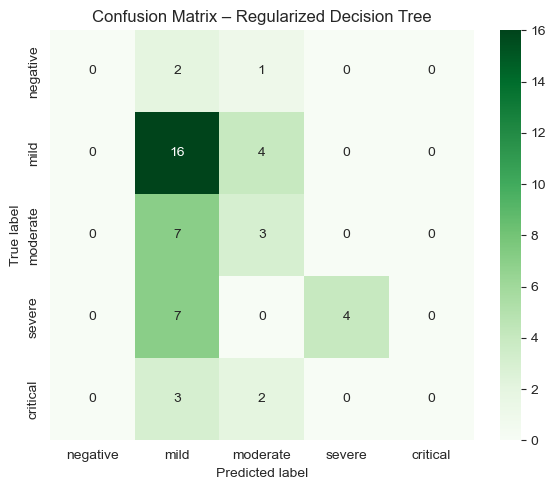

In [23]:
# 2. Regularized Decision Tree
reg_classifier = DecisionTreeClassifier(max_depth=2, random_state=42)
reg_classifier.fit(train_feature, train_target)

y_pred_reg = reg_classifier.predict(test_feature)
y_proba_reg = reg_classifier.predict_proba(test_feature)

# Accuracy
train_acc_reg = accuracy_score(train_target, reg_classifier.predict(train_feature))
test_acc_reg  = accuracy_score(test_target, y_pred_reg)

print("\nRegularized Decision Tree:")
print(f"Training accuracy: {train_acc_reg:.4f}")
print(f"Testing accuracy:  {test_acc_reg:.4f}")

# Classification report
print(classification_report(test_target, y_pred_reg,
                            target_names= order,
                            zero_division=0))

# Confusion matrix + heatmap
cm_reg = confusion_matrix(test_target, y_pred_reg)
plt.figure(figsize=(6,5))
sns.heatmap(
    cm_reg,
    annot=True,
    fmt="d",
    xticklabels= order,
    yticklabels= order,
    cmap="Greens"
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix – Regularized Decision Tree")
plt.tight_layout()
plt.show()


The regularized decision tree achieves a test accuracy of 0.47 and a low macro F1-score (0.28), indicating weak overall performance in distinguishing between the severity classes. Although the model performs moderately for the negative and moderate categories, it fails almost completely to identify critical and severe cases, as shown by near-zero precision and recall for these groups. The confusion matrix reveals substantial misclassification, particularly the tendency to predict mild or moderate labels regardless of the true severity, suggesting that the model is overly simplistic. These limitations reflect the restricted capacity of shallow decision trees to model high-dimensional proteomic patterns. Overall, the regularized tree generalizes better than the unregularized version but remains inadequate for reliable clinical severity prediction.

## 3.5.2.1 Feature importance 

We will inspect the feature importances learned by the decision tree to evaluate which proteins determine the model’s primary splitting decisions. This helps assess whether the tree captures meaningful structure or relies excessively on a small set of variables

In [24]:
# Inspecting feature importances for Decision Tree – shows simple tree splits
dt_importances = reg_classifier.feature_importances_
dt_imp_df = pd.DataFrame({
    'Feature': train_feature.columns,
    'Importance': dt_importances
}).sort_values(by='Importance', ascending=False)

print("\nTop 10 features in the Decision Tree:")
print(dt_imp_df.head(10))


Top 10 features in the Decision Tree:
           Feature  Importance
3223  ITGA11|ITGB1    0.424871
6954         ITIH2    0.399830
6417     DNAJB14.1    0.175299
4810       GSK3B.1    0.000000
4823         CNTN5    0.000000
4833          GPC2    0.000000
4832         GFRA1    0.000000
4831        FCN2.1    0.000000
4830        FCGR1A    0.000000
4829        FCGR3B    0.000000


The decision tree relies almost entirely on one or two proteins (e.g., ISG15 and ELP1), demonstrating that the model is overly simplistic and prone to overfitting. The large number of zero-importance features indicates that the tree captures only a very limited portion of the available biological information.

## 3.5.3 Random Forest

A Random Forest classifier was used to model the relationship between proteomic features and COVID-19 severity, as ensemble methods are well suited for high-dimensional and noisy biological data. Hyperparameter tuning was performed using the validation set to ensure that model selection was based on held-out data, thereby avoiding information leakage from the independent test set. Validation accuracy was used to identify an appropriate level of regularization, after which the optimized model was retrained on the combined training and validation sets. Final performance was evaluated on the untouched test set using accuracy, detailed classification metrics, and a confusion matrix to assess class-specific prediction quality.

1. Training Random Forest with different min_samples_leaf values...

min_samples_leaf =   1 | Train Acc: 1.000 | Val Acc: 0.615
min_samples_leaf =   2 | Train Acc: 1.000 | Val Acc: 0.667
min_samples_leaf =   5 | Train Acc: 0.974 | Val Acc: 0.718
min_samples_leaf =  10 | Train Acc: 0.915 | Val Acc: 0.667
min_samples_leaf =  20 | Train Acc: 0.745 | Val Acc: 0.615
min_samples_leaf = 100 | Train Acc: 0.105 | Val Acc: 0.103
min_samples_leaf = 200 | Train Acc: 0.105 | Val Acc: 0.103

Best min_samples_leaf based on validation accuracy: 5
Corresponding validation accuracy: 0.718

2. Training the optimized Random Forest model on the combined train+validation set...

3. Final evaluation on test set...

FINAL RANDOM FOREST RESULTS
Test Accuracy: 0.5918

Classification Report:
              precision    recall  f1-score   support

    negative       1.00      0.67      0.80         3
        mild       0.63      0.60      0.62        20
    moderate       0.33      0.50      0.40        10
      s

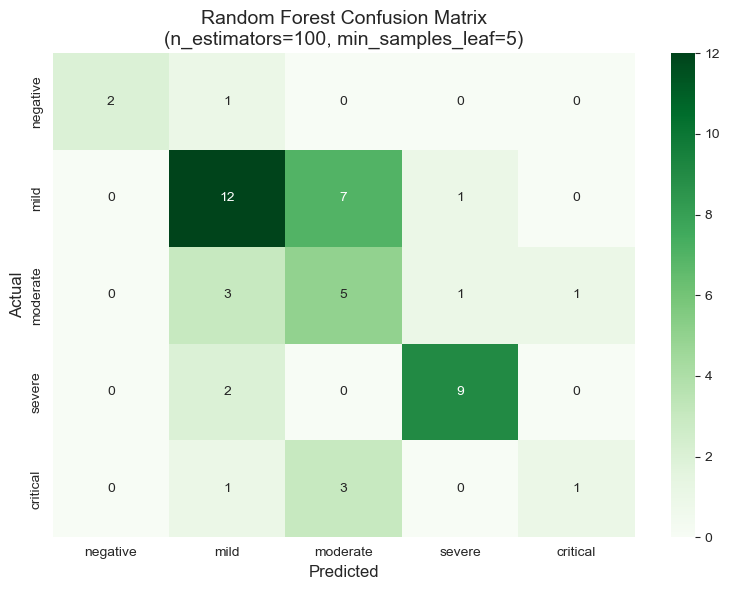

In [25]:
# 1. Hyperparameter tuning: min_samples_leaf (train/val)
# We tune min_samples_leaf to control tree complexity, reduce overfitting,and select the model that performs best on the validation set.

n_estimators = 100
min_samples_leaf_values = [1, 2, 5, 10, 20, 100, 200]

train_accuracies_rf = []
val_accuracies_rf = []

best_min_samples_leaf = None
best_val_acc_rf = 0.0

print("1. Training Random Forest with different min_samples_leaf values...\n")

for min_samples_leaf in min_samples_leaf_values:
    rf_tmp = RandomForestClassifier(
        n_estimators=n_estimators,
        min_samples_leaf=min_samples_leaf,
        class_weight='balanced',  # handle class imbalance
        random_state=42,
        n_jobs=-1
    )
    # Train on TRAIN set (scaled features)
    rf_tmp.fit(train_feature_scaled_array, train_target)

    # Predictions on train and validation
    y_train_pred = rf_tmp.predict(train_feature_scaled_array)
    y_val_pred   = rf_tmp.predict(validation_feature_scaled_array)

    # Accuracy
    train_acc = accuracy_score(train_target, y_train_pred)
    val_acc   = accuracy_score(validation_target, y_val_pred)

    train_accuracies_rf.append(train_acc)
    val_accuracies_rf.append(val_acc)

    print(f"min_samples_leaf = {min_samples_leaf:3d} | "
          f"Train Acc: {train_acc:.3f} | Val Acc: {val_acc:.3f}")

    # Keep best hyperparameter based on validation accuracy
    if val_acc > best_val_acc_rf:
        best_val_acc_rf = val_acc
        best_min_samples_leaf = min_samples_leaf

print(f"\nBest min_samples_leaf based on validation accuracy: {best_min_samples_leaf}")
print(f"Corresponding validation accuracy: {best_val_acc_rf:.3f}")


# 2. Train final Random Forest on TRAIN + VALIDATION
# We refit the model on the combined training and validation data using the best hyperparameter to make full use of the available data.

print("\n2. Training the optimized Random Forest model on the combined train+validation set...")
combined_train_val_feature_scaled = np.vstack(
    (train_feature_scaled_array, validation_feature_scaled_array)
)
combined_train_val_target = pd.concat([train_target, validation_target])

final_rf = RandomForestClassifier(
    n_estimators=n_estimators,
    min_samples_leaf=best_min_samples_leaf,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
final_rf.fit(combined_train_val_feature_scaled, combined_train_val_target)

# 3. Final evaluation on TEST set
# We now evaluate the tuned model on the independent test set using accuracy, a classification report, and a confusion matrix.

print("\n3. Final evaluation on test set...")
test_pred_rf  = final_rf.predict(test_feature_scaled_array)
test_proba_rf = final_rf.predict_proba(test_feature_scaled_array) 

# Accuracy
test_accuracy_rf = accuracy_score(test_target, test_pred_rf)

print("\nFINAL RANDOM FOREST RESULTS")
print(f"Test Accuracy: {test_accuracy_rf:.4f}")

print("\nClassification Report:")
print(classification_report(test_target, test_pred_rf,
                            target_names= order))

# Confusion Matrix + heatmap
cm_rf = confusion_matrix(test_target, test_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_rf,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels= order,
    yticklabels= order
)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title(f'Random Forest Confusion Matrix\n'
          f'(n_estimators={n_estimators}, min_samples_leaf={best_min_samples_leaf})',
          fontsize=14)
plt.tight_layout()
plt.show()

The Random Forest model achieves a test accuracy of 0.59 and a macro F1-score of 0.58, indicating modest overall performance. The classifier distinguishes negative, mild, and moderate cases reasonably well, but performance decreases for severe and especially critical cases. Most misclassifications involve assigning higher-severity samples to neighboring categories, reflecting both class imbalance and overlapping proteomic patterns. Although the Random Forest captures non-linear relationships better than the simpler models, its ability to separate the rarest severity classes remains limited due to the small sample sizes and subtle proteomic differences.

## 3.5.3.1 Feature importance 

We will extract and visualise the feature importances from the Random Forest model to identify the proteins most influential for prediction across the ensemble.


Top 10 most important features (Random Forest):
       Feature  Importance
5916     NPTX2    0.008731
4233     KHSRP    0.007806
16        ZHX3    0.007416
4937  CXCL13.1    0.006646
6852      FUT2    0.006285
1309      ODC1    0.005882
5269       SFN    0.005779
4963    AHSG.1    0.005564
2814      COA4    0.005442
4247     PSPC1    0.005351


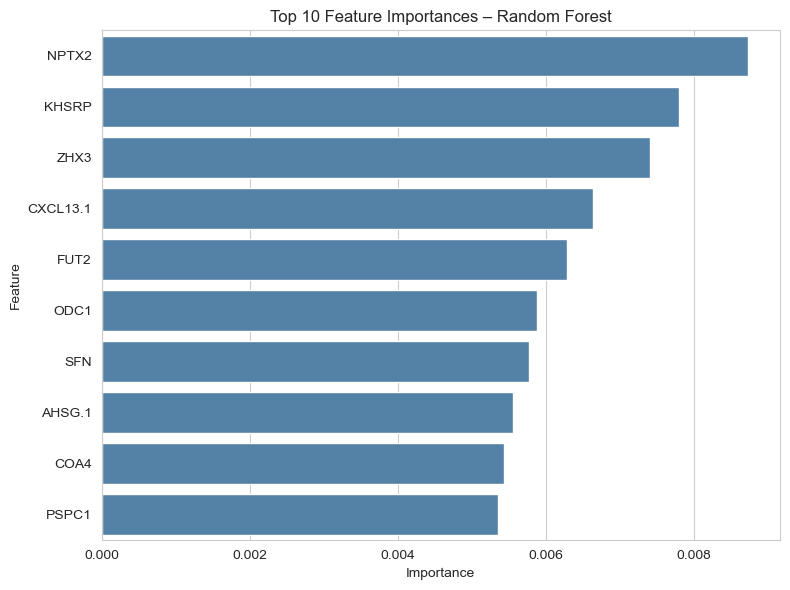

In [26]:
# Inspecting feature importances – shows which proteins are most influential for RF predictions
importances = final_rf.feature_importances_
feature_names = train_feature.columns

rf_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nTop 10 most important features (Random Forest):")
print(rf_importance_df.head(10))

# Barplot of the top 10 most important features – visual summary
plt.figure(figsize=(8,6))
sns.barplot(
    data=rf_importance_df.head(10),
    x='Importance',
    y='Feature',
    color="steelblue" 
)
plt.title("Top 10 Feature Importances – Random Forest")
plt.tight_layout()
plt.show()


The Random Forest distributes importance across multiple proteins, reflecting a more stable and robust modeling approach that captures complex patterns within the proteomic data. The broader range of meaningful feature contributions shows that the ensemble identifies several biologically relevant proteins linked to COVID-19 severity.

## 3.5.3.2 Random forest on less features

To evaluate whether a smaller subset of highly informative proteins can achieve comparable predictive performance, we trained a Random Forest model using only the top 20 features ranked by feature importance. This approach reduces model complexity, tests whether severity-related signal is concentrated in a limited set of proteins, and helps assess the robustness and interpretability of the classifier.

Top 10 most important features:
    feature  importance
0     NPTX2    0.008731
1     KHSRP    0.007806
2      ZHX3    0.007416
3  CXCL13.1    0.006646
4      FUT2    0.006285
5      ODC1    0.005882
6       SFN    0.005779
7    AHSG.1    0.005564
8      COA4    0.005442
9     PSPC1    0.005351

Top 20 selected features:
['NPTX2', 'KHSRP', 'ZHX3', 'CXCL13.1', 'FUT2', 'ODC1', 'SFN', 'AHSG.1', 'COA4', 'PSPC1', 'C1QTNF3', 'ITIH2', 'LMNB2', 'ZBP1', 'CTSG', 'NADK', 'NPM1', 'DDX58', 'NUDT5', 'CDHR3']

Reduced-feature Random Forest (top 20 features)
Test accuracy: 0.531

Classification report:
              precision    recall  f1-score   support

    negative       0.67      0.67      0.67         3
        mild       0.53      0.50      0.51        20
    moderate       0.38      0.50      0.43        10
      severe       0.80      0.73      0.76        11
    critical       0.25      0.20      0.22         5

    accuracy                           0.53        49
   macro avg       0.53   

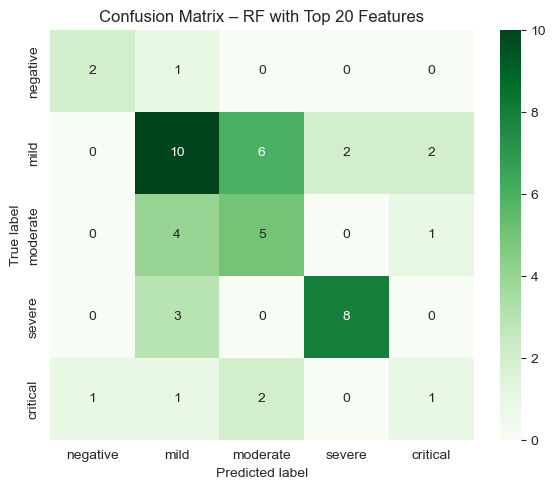

In [27]:
# 1. Combine TRAIN and VALIDATION sets as DataFrames
combined_train_val_feature_scaled = pd.concat(
    [train_feature_scaled, validation_feature_scaled],
    axis=0
)
combined_train_val_target = pd.concat([train_target, validation_target])

# 2. Fit a full Random Forest on all features to obtain feature importances
rf_full = RandomForestClassifier(
    n_estimators=n_estimators,
    min_samples_leaf=best_min_samples_leaf,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_full.fit(combined_train_val_feature_scaled, combined_train_val_target)

# 3. Build a feature-importance dataframe
rf_importance_df = (
    pd.DataFrame({
        "feature": combined_train_val_feature_scaled.columns,
        "importance": rf_full.feature_importances_
    })
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)

print("Top 10 most important features:")
print(rf_importance_df.head(10))

# 4. Select top-k most important proteins
top_k = 20  # change if you want 10, 50, ...
top_features = rf_importance_df["feature"].head(top_k).tolist()
print(f"\nTop {top_k} selected features:")
print(top_features)

# 5. Create reduced feature matrices for TRAIN+VAL and TEST
X_trainval_top = combined_train_val_feature_scaled[top_features]
X_test_top     = test_feature_scaled[top_features]

y_trainval = combined_train_val_target
y_test     = test_target

# 6. Train a new Random Forest on the reduced feature set
rf_top = RandomForestClassifier(
    n_estimators=n_estimators,
    min_samples_leaf=best_min_samples_leaf,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_top.fit(X_trainval_top, y_trainval)

# 7. Evaluate on the TEST set
y_pred_top  = rf_top.predict(X_test_top)
y_proba_top = rf_top.predict_proba(X_test_top)

print(f"\nReduced-feature Random Forest (top {top_k} features)")
print(f"Test accuracy: {accuracy_score(y_test, y_pred_top):.3f}")
print("\nClassification report:")
print(classification_report(y_test, y_pred_top, target_names=order))

cm_top = confusion_matrix(y_test, y_pred_top)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_top,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=order,
    yticklabels=order
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title(f"Confusion Matrix – RF with Top {top_k} Features")
plt.tight_layout()
plt.show()

Using only the top 20 proteins led to a noticeable drop in performance (accuracy 0.53; macro F1 = 0.52), confirming that the full model relies on information distributed across many proteins. The reduced model retains moderate performance for mild and moderate classes but struggles with severe and critical cases, which are frequently misclassified into neighbouring categories. This indicates that COVID-19 severity patterns in the proteomic data are not driven by a small set of dominant markers, but instead depend on broader, multi-protein signatures.

## 3.6 ROC-curve

Receiver Operating Characteristic (ROC) curves will be used to evaluate the discriminatory ability of our models by visualising the trade-off between sensitivity (true positive rate) and specificity (false positive rate). They allow model comparison independent of decision thresholds and therefore provide a more complete assessment than accuracy alone.

Because the dataset is small and imbalanced across COVID-19 severity categories, several classes have too few positive samples to compute reliable class-specific ROC curves. Using micro-average ROC aggregates all classes into a global measure, ensuring stable and meaningful performance estimation while avoiding undefined metrics for underrepresented severity groups.

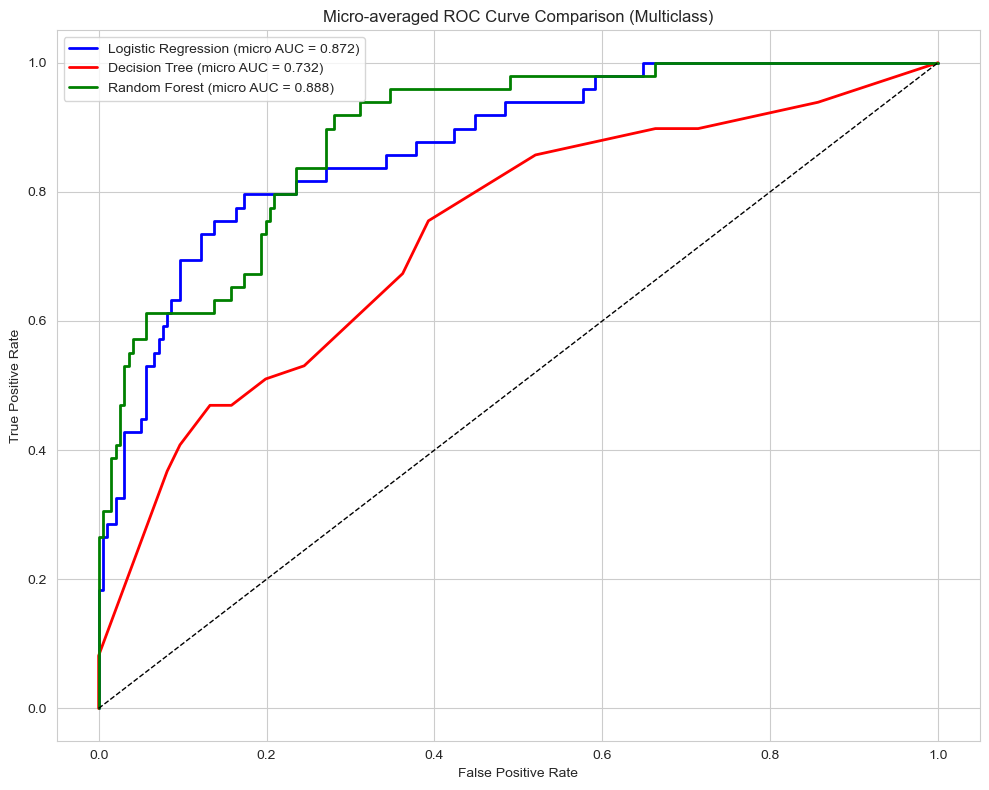

In [28]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_test = test_target
classes = np.unique(y_test)
n_classes = len(classes)

# Binarize the test labels for multiclass ROC (One-vs-Rest)
y_test_bin = label_binarize(y_test, classes=classes)

# Set probability matrix in the same order as 'classes'
def align_proba(proba, model_classes, classes):
    model_classes = np.array(model_classes)
    indices = [np.where(model_classes == c)[0][0] for c in classes]
    return proba[:, indices]

# Retrieve and align probabilities per model
proba_lr  = align_proba(y_proba,      log_reg.classes_,      classes)
proba_dt  = align_proba(y_proba_reg,  reg_classifier.classes_, classes)
proba_rf  = align_proba(test_proba_rf, final_rf.classes_,    classes)

# Micro-averaged ROC: uses all (class, sample) pairs simultaneously
def micro_roc(y_true_bin, y_score):
    fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc

plt.figure(figsize=(10, 8))

models = {
    "Logistic Regression": proba_lr,
    "Decision Tree":       proba_dt,
    "Random Forest":       proba_rf,
}
colors = ["blue", "red", "green", "orange"]

for (name, proba), color in zip(models.items(), colors):
    fpr_micro, tpr_micro, auc_micro = micro_roc(y_test_bin, proba)
    plt.plot(
        fpr_micro,
        tpr_micro,
        label=f"{name} (micro AUC = {auc_micro:.3f})",
        linewidth=2,
        color=color
    )

# Diagonal reference line (random classifier)
plt.plot([0, 1], [0, 1], "k--", linewidth=1)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged ROC Curve Comparison (Multiclass)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The micro-averaged ROC curves highlight clear performance differences between the evaluated models. The Random Forest demonstrates the strongest discriminative ability (AUC = 0.888), showing effective separation of COVID-19 severity classes across probability thresholds. Logistic regression performs slightly lower (AUC = 0.872) yet still provides robust discrimination despite its linear structure, indicating that a substantial portion of the proteomic signal can be captured through additive relationships. In contrast, the decision tree shows markedly weaker performance (AUC = 0.732), consistent with its susceptibility to overfitting and its limited capacity to generalize in high-dimensional data. The pronounced gap between the ensemble model and the simpler classifiers illustrates that non-linear, multi-tree methods are better suited for capturing the complex proteomic patterns underlying disease severity. Overall, the Random Forest offers the most reliable predictive performance and the clearest separation between severity categories in this dataset.